# Úkol č. 1 - redukce dimenzionality a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz/BI-ML2/homeworks/index.html](https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzazším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>

  * Použijte natrénovaný generativní model Naivního Bayesova klasifikátoru nebo Lineární diskriminační analýzy (podle Vaší volby) a vygenerujte pro každou třídu 5 datových bodů, které následně přetransformujte do rozměrů 28x28 a zobrazte pomocí `imshow`. Diskutujte kvalitu vygenerovaných dat. K vygenerování můžete využít funkci [multivariate_normal](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.multivariate_normal.html) z `numpy`.

  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky aplikace modelů (žádné další generování už nedělejte) a pokuste se je vylepšit.
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
       * Ukázka, jak by mělo vypadat prvních několik řádků souboru `results.csv` (obecně s jinými hodnotami):
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [75]:
import pandas as pd
import numpy as np

random_seed = 42

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

## Příprava a přehled dat

Data si uložím do proměnných a rozdělím na trénovací, validační a testovací množiny. Pro pozdější užití vytvořím i jejich normalizované a standardizované kopie.

In [3]:
data = pd.read_csv("train.csv")
evl = pd.read_csv("evaluate.csv")

In [4]:
Xdata = data.drop(columns="label")
Ydata = data.label

In [105]:
scaler = MinMaxScaler()
XtrainMinMax = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
XvalMinMax = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)
XtestMinMax = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)

In [18]:
scaler = StandardScaler()
XtrainStandard = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
XvalStandard = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)

In [5]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=0.4, random_state=random_seed)
Xval, Xtest, Yval, Ytest = train_test_split(Xtest, Ytest, test_size=0.5, random_state=random_seed)

In [125]:
print(np.unique(Ytest, return_counts=True))

(array([0, 1]), array([158, 142]))


Dataset obsahuje 1500 vzorků a každý obrázek má 784 pixelů, každý pixel nabývá hodnot od 0 do 255.

In [6]:
print(data.shape)
data.head()

(1500, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,95,132,90,0,0,0
2,1,0,0,0,0,0,0,3,0,23,...,94,68,44,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,57,0,0,0,26,71,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,6,156,149,78,0,0,0,0


In [8]:
data.isnull().sum().sum()

0

Dataset neobsahuje žádné prázdné hodnoty. Není tedy nutné je doplňovat. Níže zobrazím 7 obrázků z každé kategorie. Kategorie jsou dvě - 0, která znamená nejspíš košile/saka a 1 znamená šaty.

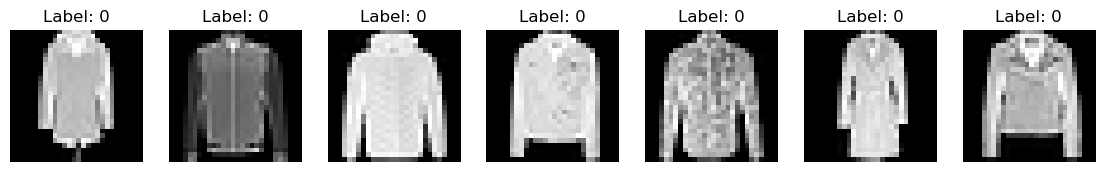

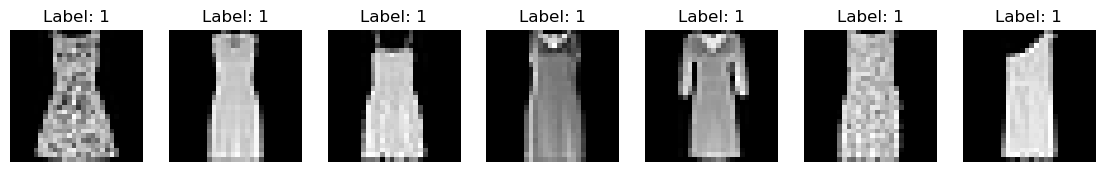

In [9]:
def show_images(df, label, n):
    imgs = df[df['label'] == label].iloc[:n, 1:].values.reshape(-1, 28, 28)
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2))
    for i, img in enumerate(imgs):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

show_images(data, label=0, n=7)
show_images(data, label=1, n=7)

## Metoda podpůrných vektorů

### Výhody 
* poradí si s vysokodimenzionálními daty i bez redukce dimenze
* díky regularizačnímu parametru C je robustní vůči přeučení
* vhodný pro binární klasifikaci
* vysoká přesnost
* využívá jádrové funkce, díky tomu se umí přizpůsobit různě distribuovaným datům

### Nevýhody
* výpočetně a paměťově náročnější

### Hyperparametry
* **C**: regularizační parametr, větší C znamená méně chyb, ale větší margin, menší C opak
* **kernel**: jádrová funkce, která rozděluje prostor vysvětlované proměnné na dvě části
* **gamma**: parametr pro jádrové funkce rbf a poly, určuje, jak blízké body se budou brát v potaz
* **degree**: stupeň polynomu pro poly jádrovou funkci
* **normalization**: SVM funguje lépe, pokud jsou data ve stejném rozsahu, proto zkouším normalizace

In [131]:
SVM_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['poly', 'rbf', 'linear'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'normalization' : [None, 'MinMax', 'Standard']
}

SVM_param_comb = ParameterGrid(SVM_param_grid)
print(f"Počet možných kombinací hyperparametrů: {len(SVM_param_comb)}")

Počet možných kombinací hyperparametrů: 270


In [129]:
SVM_best_params = None
SVM_train_acc = []
SVM_val_acc = []

for par in SVM_param_comb:
    XtrainCopy = Xtrain.copy()
    XvalCopy = Xval.copy()
    
    if par['normalization'] == 'Standard':
        XtrainCopy = XtrainStandard.copy()
        XvalCopy = XvalStandard.copy()
    elif par['normalization'] == 'MinMax':
        XtrainCopy = XtrainMinMax.copy()
        XvalCopy = XvalMinMax.copy()
    
    clf = SVC(C=par['C'], kernel=par['kernel'], gamma=par['gamma'], degree=par['degree'])
    clf.fit(XtrainCopy, Ytrain)
    SVM_train_acc.append(metrics.accuracy_score(Ytrain, clf.predict(XtrainCopy)))
    SVM_val_acc.append(metrics.accuracy_score(Yval, clf.predict(XvalCopy)))

In [130]:
SVM_best_params = SVM_param_comb[np.argmax(SVM_val_acc)]
print('Nejlepší parametry pro SVM:', SVM_best_params)

Nejlepší parametry pro SVM: {'normalization': 'MinMax', 'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'C': 10}


In [28]:
SVM_best_params.pop('normalization', None)
SVM_best_clf = SVC(**SVM_best_params) 
SVM_best_clf.fit(XtrainMinMax, Ytrain)
SVM_val_acc_best = metrics.accuracy_score(Yval, SVM_best_clf.predict(XvalMinMax))
print('Přesnost na trénovací množině: {0:.6f}'.format(metrics.accuracy_score(Ytrain, SVM_best_clf.predict(XtrainMinMax))))
print('Přesnost na validační množině: {0:.6f}'.format(SVM_val_acc_best))

Přesnost na trénovací množině: 0.968889
Přesnost na validační množině: 0.936667


In [27]:
SV = SVM_best_clf.support_.shape[0]
print(f"Počet podpůrných vektorů {SV} tvoří {100*SV/Xtrain.shape[0]:.1f} % trénovací množiny.")

Počet podpůrných vektorů 176 tvoří 19.6 % trénovací množiny.


Přesnost mi vyšla velmi vysoká. 
Podpůrných vektorů je pouze necelých 20 procent z celých trénovacích dat, což je dobrý výsledek. Znamená to, že model našel dobře oddělitelnou hranici mezi oběma třídami, což povede k lepší generalizaci a přesnosti na datech, která ještě neviděl. 

## Naivní Bayesův klasifikátor

### Výhody 
* rychlost - model počítá pravděpodobnosti
* jednoduchý model - nemá žádné hyperparametry, já opět zkouším jen normalizace dat 

### Nevýhody
* předpokládá nezávislost vstupních atributů, to však není vždy splněno, ale i přesto někdy dává překvapivě dobré výsledky
* pokud nejsou splněny předpoklady, vede k horším výsledkům

In [33]:
NB_best_params = None
NB_train_acc = []
NB_val_acc = []
NB_param_grid = {
    'normalization' : ['MinMax', 'Standard', 'No']
}
NB_param_comb = ParameterGrid(NB_param_grid)

In [133]:
for par in NB_param_comb:
    XtrainCopy = Xtrain.copy()
    XvalCopy = Xval.copy()
    
    if par['normalization'] == 'Standard':
        XtrainCopy = XtrainStandard.copy()
        XvalCopy = XvalStandard.copy()
    elif par['normalization'] == 'MinMax':
        XtrainCopy = XtrainMinMax.copy()
        XvalCopy = XvalMinMax.copy()
    
    clf = GaussianNB();
    clf.fit(XtrainCopy, Ytrain)
    NB_train_acc.append(metrics.accuracy_score(Ytrain, clf.predict(XtrainCopy)))
    NB_val_acc.append(metrics.accuracy_score(Yval, clf.predict(XvalCopy)))

In [134]:
NB_best_params = NB_param_comb[np.argmax(NB_val_acc)]
print('Nejlepší parametry pro NB:', NB_best_params)

Nejlepší parametry pro NB: {'normalization': 'MinMax'}


In [135]:
NB_best_clf = GaussianNB();
NB_best_clf.fit(XtrainMinMax, Ytrain)
NB_val_acc_best = metrics.accuracy_score(Yval, NB_best_clf.predict(XvalMinMax))
print('Přesnost na trénovací množině: {0:.6f}'.format(metrics.accuracy_score(Ytrain, NB_best_clf.predict(XtrainMinMax))))
print('Přesnost na validační množině: {0:.6f}'.format(NB_val_acc_best))

Přesnost na trénovací množině: 0.878889
Přesnost na validační množině: 0.836667


In [137]:
Ypred = NB_best_clf.predict(XvalMinMax)
print(f"Z {Xval.shape[0]} bodů validační množiny je špatně klasifikovaných: {(Yval != Ypred).sum()}")

Z 300 bodů validační množiny je špatně klasifikovaných: 49


## Lineární diskriminační analýza

### Výhody 
* rychlost
* robustní vůči multikolinearitě

### Nevýhody
* nevhodné pro nelineární data
* předpokládá pro jednotlivé třídy normální rozdělení, což nemusí být vždy splněno

Opět nemá hyperparametry, takže jen zkusím normalizaci dat.

In [44]:
LDA_best_params = None
LDA_train_acc = []
LDA_val_acc = []

In [47]:
for par in NB_param_comb:
    XtrainCopy = Xtrain.copy()
    XvalCopy = Xval.copy()
    
    if par['normalization'] == 'Standard':
        XtrainCopy = XtrainStandard.copy()
        XvalCopy = XvalStandard.copy()
    elif par['normalization'] == 'MinMax':
        XtrainCopy = XtrainMinMax.copy()
        XvalCopy = XvalMinMax.copy()
    
    clf = LinearDiscriminantAnalysis();
    clf.fit(XtrainCopy, Ytrain)
    LDA_train_acc.append(metrics.accuracy_score(Ytrain, clf.predict(XtrainCopy)))
    LDA_val_acc.append(metrics.accuracy_score(Yval, clf.predict(XvalCopy)))

In [138]:
LDA_best_params = NB_param_comb[np.argmax(LDA_val_acc)]
print('Nejlepší parametry pro LDA:', LDA_best_params)

Nejlepší parametry pro LDA: {'normalization': 'MinMax'}


In [139]:
LDA_best_clf = LinearDiscriminantAnalysis();
LDA_best_clf.fit(XtrainMinMax, Ytrain)
LDA_val_acc_best = metrics.accuracy_score(Yval, LDA_best_clf.predict(XvalMinMax))
print('Přesnost na trénovací množině: {0:.6f}'.format(metrics.accuracy_score(Ytrain, LDA_best_clf.predict(XtrainMinMax))))
print('Přesnost na validační množině: {0:.6f}'.format(LDA_val_acc_best))

Přesnost na trénovací množině: 1.000000
Přesnost na validační množině: 0.800000


Dokonalá přesnost na trénovacích datech může vzbudit obavy z přeučení, avšak 80 procent na validačních značí dobrou výkonnost modelu.

## Generování nových bodů

K vygenerování nových obrázků používám funkci multivariate_normal, která pro obě třídy spočítá průměr a kovarianční matici. Průměr slouží k určení průměrného obrázku z každé třídy, kovarianční matice k určení rozptylu a závislosti mezi pixely. Z těchto hodnot i za pomocí náhody vytvoří 5 obrázků připomínající původní data pro každou třídu.

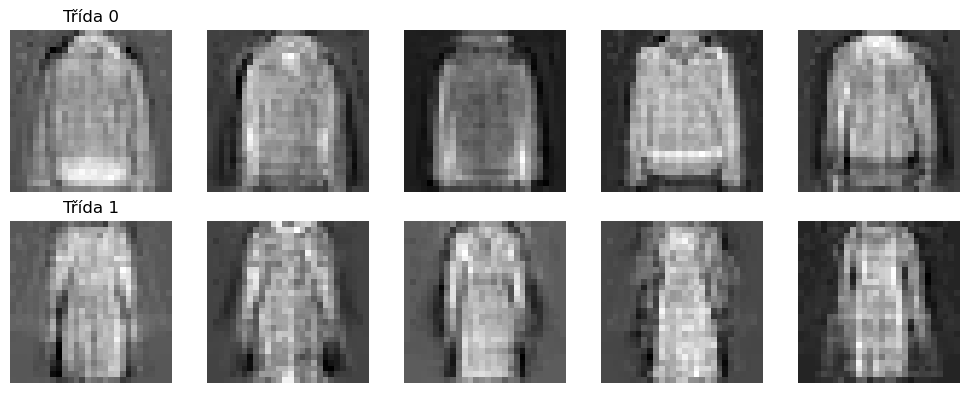

In [142]:
lda = LinearDiscriminantAnalysis()
lda.fit(XtrainMinMax, Ytrain)

classes = np.unique(Ytrain)
n_samples = 5

fig, axs = plt.subplots(len(classes), n_samples, figsize=(10, 4))

for i, cls in enumerate(classes):
    class_data = XtrainMinMax[Ytrain == cls]

    mean = class_data.mean(axis=0)
    cov = np.cov(class_data, rowvar=False)

    samples = np.random.multivariate_normal(mean, cov, n_samples)

    for j in range(n_samples):
        img = samples[j].reshape(28, 28)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(f"Třída {cls}")

plt.tight_layout()
plt.show()

Mezi původními obrázky jde vidět významný rozdíl. Tyto nové jsou více rozmazané a oděvy nemají vždy jasné hranice, dokonce to někdy i vypadá, že je více oděvů na jednom obrázku, ale i tak jde poznat, jaký kus oblečení na obrázku je. Takto si model představuje průměrné případy z každé třídy. Dále na původních datech je černé pozadí, ale na nových obrázcích je pozadí šedivé. To se děje proto, že funkce počítá s průměrem barvy pixelů, a ten nikdy nemůže být 0 - tedy černá, protože se do něj započítávají i pixely označující oděv.

## Redukce dimenzionality

In [230]:
zero_pixels = sum((Xtrain == 0).all())
print(zero_pixels)

27


V trénovacím datasetu je 27 pixelů, které jsou na každém obrázku černé, tyto pixely a sloupce jsou pro trénování nepotřebné a proto by redukce dimenze mohla vést k přesnějším modelům.

### PCA

Principal component analysis - analýza hlavních komponentů transformuje vysokorozměrná data do podoby, kdy obsahují pouze určité množství hlavních komponent (příznaků, dimenzí), které vznikají jako lineární kombinace původních příznaků. Postupně ji použiju na modely SVM, NB a LDA.

#### Metoda podpůrných vektorů

Jelikož by učení za použití mého původního množství hyperparametrů trvalo příliš dlouho, zredukovala jsem je na pouze dva nejdůležitější a zúžila z nich výběr. Dále používám maximálně 80 komponent, protože poté se už přesnost modelu nezvyšuje.

In [206]:
PCA_SVM_param_grid = {
    'C': [0.1, 1, 10],   
    'kernel': ['poly', 'rbf']        
}
PCA_SVM_param_comb = ParameterGrid(PCA_SVM_param_grid) 

In [207]:
PCA_SVM_val_acc = []
PCA_SVM_best_acc = 0
PCA_SVM_best_dim = 0
PCA_SVM_best_model = None
best_pca_SVM = None
best_config_pca_svm = {}

for i in range(1, 80, 3):
    pca = PCA(n_components=i)
    Xtrain_pca = pca.fit_transform(Xtrain)
    Xval_pca = pca.transform(Xval)

    for par in PCA_SVM_param_comb:
        clf = SVC(C=par['C'], kernel=par['kernel'])
        clf.fit(Xtrain_pca, Ytrain)  
        current_val_acc = metrics.accuracy_score(Yval, clf.predict(Xval_pca))  
        PCA_SVM_val_acc.append(current_val_acc) 
    
        if current_val_acc > PCA_SVM_best_acc:
            PCA_SVM_best_acc = current_val_acc
            PCA_SVM_best_dim = i
            PCA_SVM_best_model = clf
            best_pca_SVM = pca
            best_config_pca_svm = {
                'pca_n_components': i,
                'svc_C': par['C'],
                'svc_kernel': par['kernel']
            }

In [208]:
print("Nejlepší počet PCA komponent/dimenze:", PCA_SVM_best_dim)
print("Validační přesnost při nejlepší dimenzi:", PCA_SVM_best_acc)

Nejlepší počet PCA komponent/dimenze: 55
Validační přesnost při nejlepší dimenzi: 0.9533333333333334


In [212]:
print("Nejlepší parametry SVM:")
print(f"C: {best_config_pca_svm['svc_C']}")
print(f"kernel: {best_config_pca_svm['svc_kernel']}")

Nejlepší parametry SVM:
C: 10
kernel: rbf


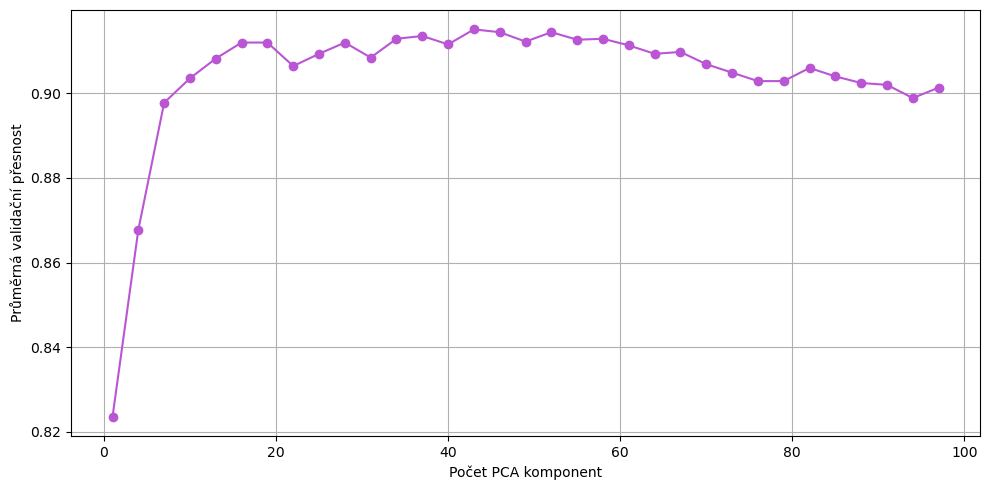

In [167]:
dims = list(range(1, 100, 3))
n_combinations = len(PCA_SVM_param_comb)
val_acc_matrix = np.array(PCA_SVM_val_acc).reshape(len(dims), n_combinations)
mean_val_acc = val_acc_matrix.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(dims, mean_val_acc, marker='o', linestyle='-', color='mediumorchid')
plt.xlabel("Počet PCA komponent")
plt.ylabel("Průměrná validační přesnost")
plt.grid(True)
plt.tight_layout()
plt.show()

Nejlepší dimenze vyšla 55. Výsledky jsem zobrazila do grafu, ze kterého je patrné, že při použití prvních pár komponent je přesnost modelu poměrně nízká, to protože jeden či tři příznaky nestačí k popsání celého chování dat, poté se ale výkonnost modelu zvyšuje a ke konci už jemně klesá.

#### Naivní Bayesův klasifikátor

U NB a LDA nejsou hyperparametry k ladění, použiju tedy jen parametr počet komponent u PCA.

In [155]:
PCA_NB_val_acc = []
PCA_NB_best_acc = 0
PCA_NB_best_dim = 0
PCA_NB_best_model = None
best_pca_NB = None

for i in range(1, 100, 3):
    pca = PCA(n_components=i)
    Xtrain_pca = pca.fit_transform(Xtrain)
    Xval_pca = pca.transform(Xval)
    
    clf = GaussianNB()
    clf.fit(Xtrain_pca, Ytrain)
    
    current_val_acc = metrics.accuracy_score(Yval, clf.predict(Xval_pca))
    PCA_NB_val_acc.append(current_val_acc)
    
    if current_val_acc > PCA_NB_best_acc:
        PCA_NB_best_acc = current_val_acc
        PCA_NB_best_dim = i
        PCA_NB_best_model = clf
        best_pca_NB = pca

In [160]:
print("Nejlepší počet PCA komponent/dimenze:", PCA_NB_best_dim)
print("Validační přesnost při nejlepší dimenzi:", PCA_NB_best_acc)

Nejlepší počet PCA komponent/dimenze: 94
Validační přesnost při nejlepší dimenzi: 0.8866666666666667


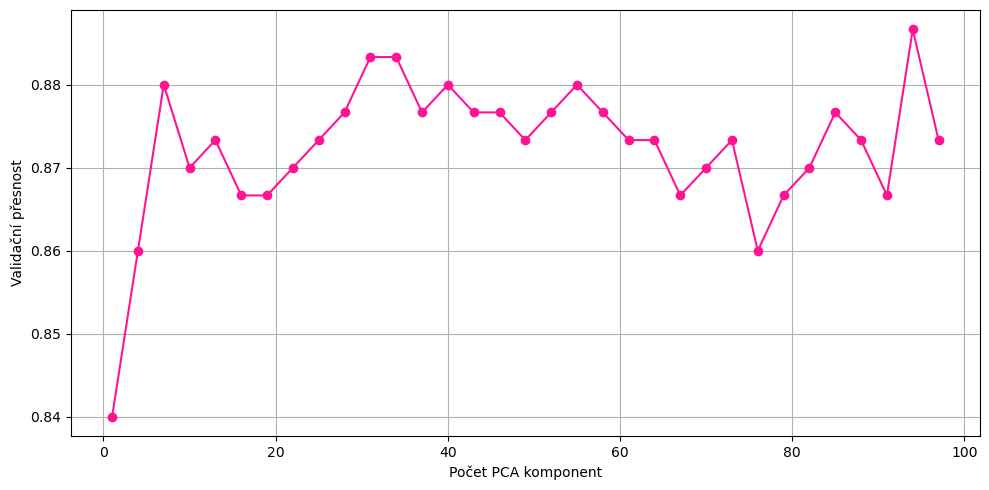

In [165]:
dims = list(range(1, 100, 3))

plt.figure(figsize=(10, 5))
plt.plot(dims, PCA_NB_val_acc, marker='o', linestyle='-', color='deeppink')
plt.xlabel("Počet PCA komponent")
plt.ylabel("Validační přesnost")
plt.grid(True)
plt.tight_layout()
plt.show()

Tady je přesnost vysoká hned od začátku a celou dobu se pohybuje kolem velmi podobných hodnot.

#### LDA

In [168]:
PCA_LDA_val_acc = []
PCA_LDA_best_acc = 0
PCA_LDA_best_dim = 0
PCA_LDA_best_model = None
best_pca_LDA = None

for i in range(1, 100, 3):
    pca = PCA(n_components=i)
    Xtrain_pca = pca.fit_transform(Xtrain)
    Xval_pca = pca.transform(Xval)
    
    clf = LinearDiscriminantAnalysis()
    clf.fit(Xtrain_pca, Ytrain)
    
    current_val_acc = metrics.accuracy_score(Yval, clf.predict(Xval_pca))
    PCA_LDA_val_acc.append(current_val_acc)

    if current_val_acc > PCA_LDA_best_acc:
        PCA_LDA_best_acc = current_val_acc
        PCA_LDA_best_dim = i
        PCA_LDA_best_model = clf
        best_pca_LDA = pca

In [169]:
print("Nejlepší počet PCA komponent/dimenze:", PCA_LDA_best_dim)
print("Validační přesnost při nejlepší dimenzi:", PCA_LDA_best_acc)

Nejlepší počet PCA komponent/dimenze: 13
Validační přesnost při nejlepší dimenzi: 0.9266666666666666


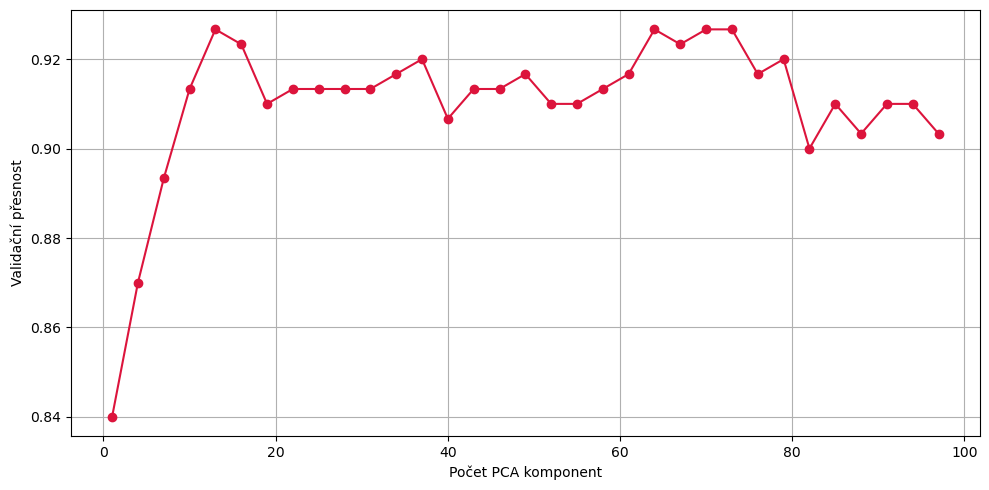

In [171]:
dims = list(range(1, 100, 3))

plt.figure(figsize=(10, 5))
plt.plot(dims, PCA_LDA_val_acc, marker='o', linestyle='-', color='crimson')
plt.xlabel("Počet PCA komponent")
plt.ylabel("Validační přesnost")
plt.grid(True)
plt.tight_layout()
plt.show()

### LLE

Lokálně lineární vnoření je taktéž metoda sloužící k redukci dimenze dat, užitečná pro nelineárně rozdělená data. Funguje tak, že pro každý datový bod najde k jeho nejbližších sousedů, tento bod vyjádří jako lineární kombinaci svých sousedů a na základě těchto čísel najde způsob reprezentace bodů v nižší dimenzi, která ale zachová původní geometrické vztahy mezi body. Jako toto k zkouším postupně čísla 5, 10, 15 a n_components v tomto případě znamená počet komponent neboli dimenzí, které vytvoří.

#### Metoda podpůrných vektorů

In [173]:
param_grid_lle = {
    'n_neighbors' : [5, 10, 15],
    'n_components' : range(1,60,3)
}
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10, 100],   
    'kernel': ['poly', 'rbf', 'linear'] 
}
param_comb_svc = ParameterGrid(param_grid_svc)
param_comb_lle = ParameterGrid(param_grid_lle)

In [228]:
LLE_SVC_results = []
LLE_SVC_best_acc = 0
best_config = {}

for lle_params in param_comb_lle:
    lle = LocallyLinearEmbedding(n_components=lle_params['n_components'], n_neighbors=lle_params['n_neighbors'],method='standard')

    Xtrain_lle = lle.fit_transform(Xtrain)
    Xval_lle = lle.transform(Xval)

    for svc_params in param_comb_svc:
        clf = SVC(**svc_params)
        clf.fit(Xtrain_lle, Ytrain)

        current_val_acc = metrics.accuracy_score(Yval, clf.predict(Xval_lle))
        LLE_SVC_results.append((lle_params, svc_params, current_val_acc))

        if current_val_acc > LLE_SVC_best_acc:
            LLE_SVC_best_acc = current_val_acc
            best_config = {
                'lle_params': lle_params,
                'svc_params': svc_params,
                'model': clf
            }

In [229]:
print("Nejlepší LLE parametry:")
print(f"  • n_neighbors = {best_config['lle_params']['n_neighbors']}")
print(f"  • n_components = {best_config['lle_params']['n_components']}")
print(f"Validační přesnost = {LLE_SVC_best_acc:.6f}")

Nejlepší LLE parametry:
  • n_neighbors = 15
  • n_components = 22
Validační přesnost = 0.946667


#### Naivní Bayesův klasifikátor

In [187]:
results_nb = []
LLE_NB_best_acc = 0
best_config_nb = {}

for n in [5, 10, 15]:
    for d in range(1, 100, 3):
        lle = LocallyLinearEmbedding(n_components=d, n_neighbors=n, method='standard')

        Xtrain_lle = lle.fit_transform(Xtrain)
        Xval_lle = lle.transform(Xval)

        clf = GaussianNB()
        clf.fit(Xtrain_lle, Ytrain)

        current_val_acc = metrics.accuracy_score(Yval, clf.predict(Xval_lle))

        results_nb.append((n, d, current_val_acc))

        if current_val_acc > LLE_NB_best_acc:
            LLE_NB_best_acc = current_val_acc
            best_config_nb = {
                'n_neighbors': n,
                'n_components': d,
                'model': clf
            }

In [189]:
print("Nejlepší LLE parametry:")
print(f"  • n_neighbors = {best_config_nb['n_neighbors']}")
print(f"  • n_components = {best_config_nb['n_components']}")
print(f"Validační přesnost = {LLE_NB_best_acc:.6f}")

Nejlepší LLE parametry:
  • n_neighbors = 10
  • n_components = 34
Validační přesnost = 0.906667


#### LDA

In [191]:
results_lda = []
LLE_LDA_best_acc = 0
best_config_lda = {}

for n in [5, 10, 15]:
    for d in range(1, 100, 3):
        lle = LocallyLinearEmbedding(n_components=d, n_neighbors=n, method='standard')

        Xtrain_lle = lle.fit_transform(XtrainMinMax)
        Xval_lle = lle.transform(XvalMinMax)

        clf = LinearDiscriminantAnalysis()
        clf.fit(Xtrain_lle, Ytrain)

        current_val_acc = metrics.accuracy_score(Yval, clf.predict(Xval_lle))

        results_lda.append((n, d, current_val_acc))

        if current_val_acc > LLE_LDA_best_acc:
            LLE_LDA_best_acc = current_val_acc
            best_config_lda = {
                'n_neighbors': n,
                'n_components': d,
                'model': clf
            }

In [192]:
print("Nejlepší LLE parametry:")
print(f"  • n_neighbors = {best_config_lda['n_neighbors']}")
print(f"  • n_components = {best_config_lda['n_components']}")
print(f"Validační přesnost = {LLE_LDA_best_acc:.6f}")

Nejlepší LLE parametry:
  • n_neighbors = 15
  • n_components = 82
Validační přesnost = 0.926667


## Výběr finálního modelu a aplikace na evaluační data

In [200]:
print("Přesnosti modelů na validační množině:")
print('{0:.6f} SVM'.format(SVM_val_acc_best))
print('{0:.6f} NB'.format(NB_val_acc_best))
print('{0:.6f} LDA'.format(LDA_val_acc_best))
print('{0:.6f} PCA SVM'.format(PCA_SVM_best_acc))
print('{0:.6f} PCA NB'.format(PCA_NB_best_acc))
print('{0:.6f} PCA LDA'.format(PCA_LDA_best_acc))
print('{0:.6f} LLE SVM'.format(LLE_SVM_best_acc))
print('{0:.6f} LLE NB'.format(LLE_NB_best_acc))
print('{0:.6f} LLE LDA'.format(LLE_LDA_best_acc))

Přesnosti modelů na validační množině:
0.936667 SVM
0.836667 NB
0.800000 LDA
0.950000 PCA SVM
0.886667 PCA NB
0.926667 PCA LDA
0.920000 LLE SVM
0.906667 LLE NB
0.926667 LLE LDA


Jako nejlepší model se jeví metoda podpůrných vektorů za použití PCA. Nejlepší parametry jsem si při tomto výpočtu vypsala a nyní je aplikuji na testovací data, abych zjistila očekávanou přesnost modelu.

In [220]:
pca = PCA(n_components=55)
X_train = pca.fit_transform(Xtrain)
X_test = pca.transform(Xtest)

svc_clf = SVC(kernel='rbf', C=10).fit(X_train, Ytrain)
print('Očekávaná přesnost modelu: {0:.6f}'.format(metrics.accuracy_score(Ytest, svc_clf.predict(X_test))))

Očekávaná přesnost modelu: 0.956667


95 procent je velmi dobrý výsledek, teď tento natrénovaný model aplikuji na evaluační data a uložím do souboru results.csv

In [ ]:
evl_index = evl.iloc[:, :1]
evl = evl.iloc[:, 1:]

evl = pca.transform(evl)
predict = svc_clf.predict(evl)

results = pd.DataFrame({'ID': evl_index.iloc[:, 0].ravel(), 'label': predict})
results.to_csv('results.csv', index=False)

In [225]:
results.head(10)

,ID,label
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,1
7,7,1
8,8,1
9,9,0
